In [174]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append("..")

In [2]:
from utils.helper import get_fmri
from utils.visualize_fmri import plot_voxel_response
import matplotlib.pyplot as plt
import numpy as np

In [69]:
all_subjects = ['sub10', 'sub09', 'sub08', 'sub07', 'sub06', 'sub05', 'sub04', 'sub03', 'sub02', 'sub01']

all_rois = ['EBA', 'FFA', 'LOC', 'PPA', 'STS',
            'V1', 'V2', 'V3', 'V4']

# How many voxels are there per region/subject?

In [70]:
import pandas as pd
roi_voxels = {}
for roi in all_rois:
    sub_voxels = []
    for sub in all_subjects:
        roi_sub = get_fmri('../data/participants_data_v2021', sub, roi, mean=False)
        voxels = roi_sub.shape[2]
        sub_voxels.append(voxels)
    roi_voxels[roi] = sub_voxels
roi_voxels["sub_id"] = all_subjects
roi_voxels = pd.DataFrame(roi_voxels)
roi_voxels

,EBA,FFA,LOC,PPA,STS,V1,V2,V3,V4,sub_id
0,162,69,1034,165,120,238,249,188,60,sub10
1,191,76,1515,262,346,271,265,245,94,sub09
2,55,163,1244,150,306,300,238,223,85,sub08
3,101,89,1117,33,80,195,189,174,55,sub07
4,308,119,1356,216,173,286,281,229,108,sub06
5,309,69,1397,210,219,326,196,176,73,sub05
6,368,210,1153,225,398,176,209,212,117,sub04
7,376,80,1237,368,278,164,271,270,111,sub03
8,183,157,1348,153,421,285,231,270,95,sub02
9,351,68,1843,425,341,232,231,261,107,sub01


(0.0, 1450.0)

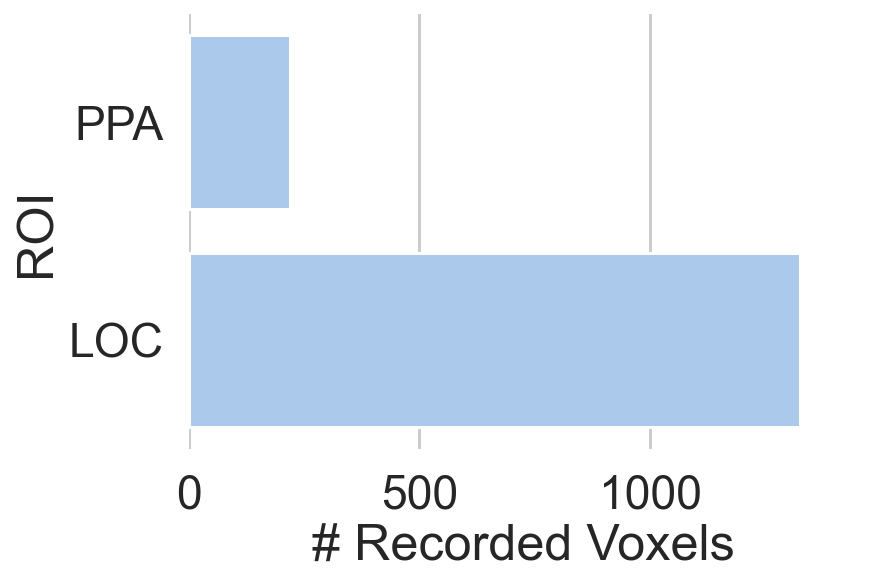

In [68]:
from mle_toolbox import visualize
import pandas as pd
sub_mean = []
sub_id = []
for roi in ["PPA", "LOC"]:    
    sub_voxels = []
    for sub in all_subjects:
        roi_sub = get_fmri('../data/participants_data_v2021', sub, roi, mean=False)
        voxels = roi_sub.shape[2]
        sub_voxels.append(voxels)
    sub_id.append(roi)
    sub_mean.append(np.mean(sub_voxels))
roi_voxels = {"ROI": sub_id,
              "# Recorded Voxels": sub_mean}
roi_voxels = pd.DataFrame(roi_voxels)

import seaborn as sns
sns.set_context("talk", font_scale=1.4)
#sns.set_theme(style="whitegrid")
# Plot the total crashes
#sns.set_color_codes("pastel")
f, ax = plt.subplots()
sns.barplot(data=roi_voxels, x="# Recorded Voxels", y="ROI",
            label="Total", color="b")
sns.despine(left=True, bottom=True)
ax.set_xlim(0, 1450)

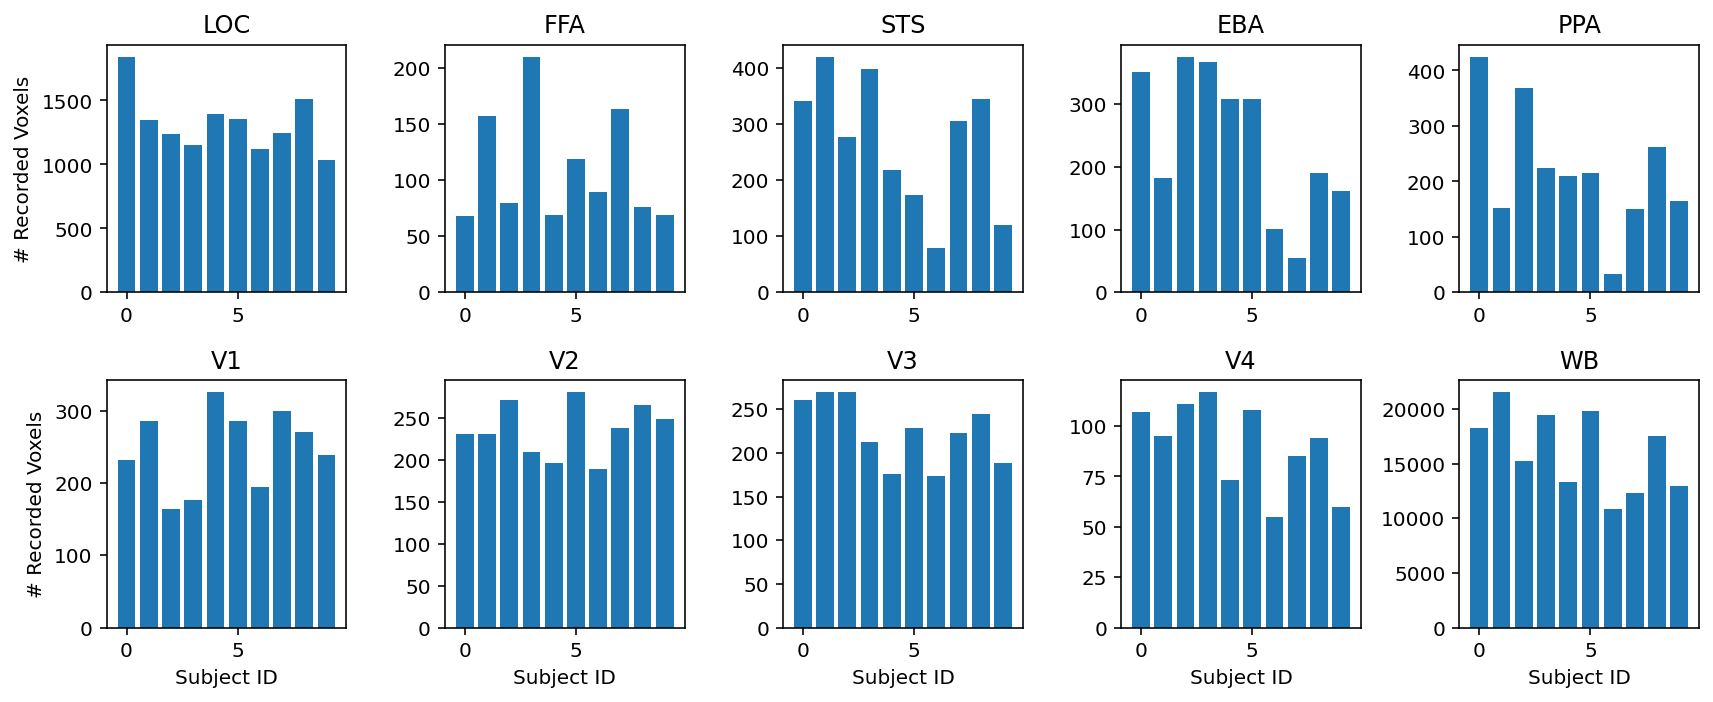

In [37]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, roi in enumerate(all_rois):
    axs.flatten()[i].bar(np.arange(10), roi_voxels[roi])
    axs.flatten()[i].set_title(roi)
    if i == 0 or i == 5:
        axs.flatten()[i].set_ylabel("# Recorded Voxels")
    if i in [5, 6, 7, 8, 9]:
        axs.flatten()[i].set_xlabel("Subject ID")
fig.tight_layout()

# Plot Voxel-Response across Subjects for Same Video

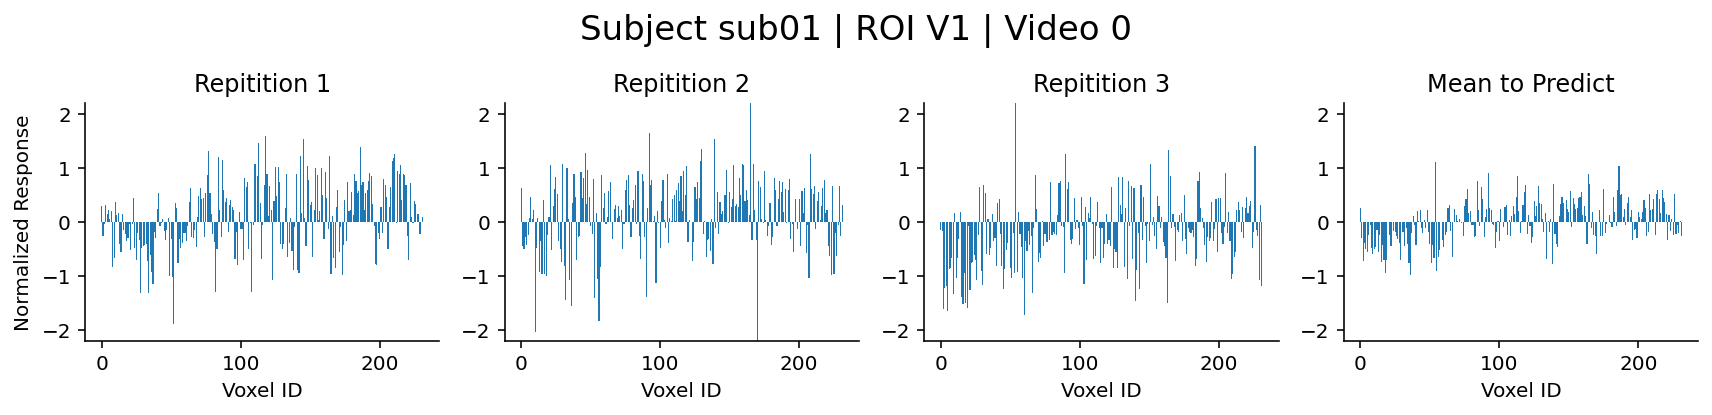

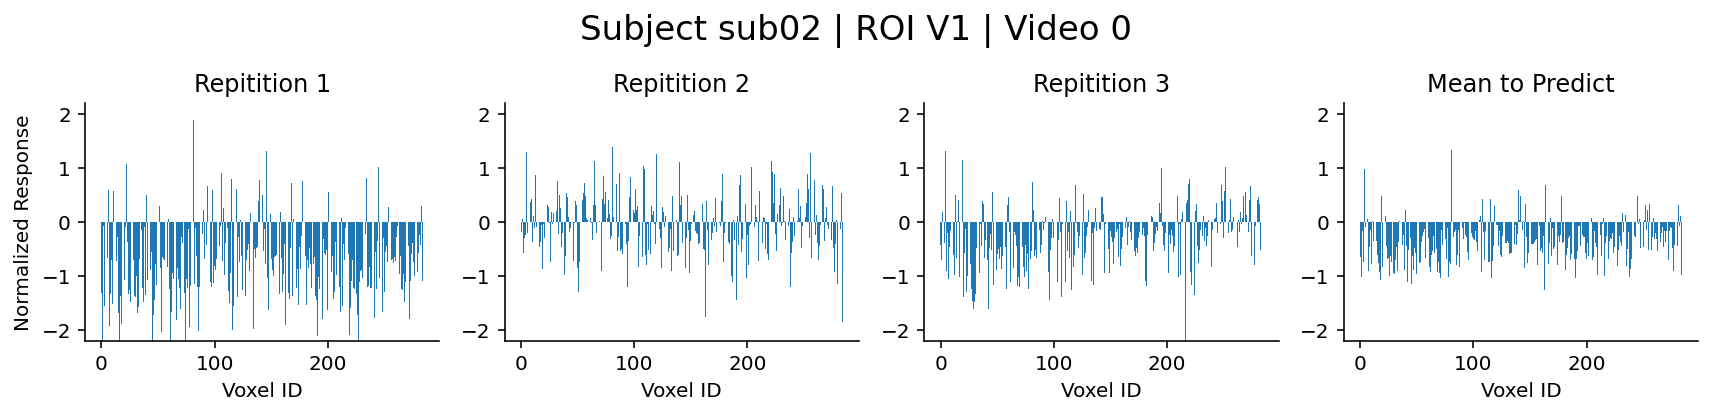

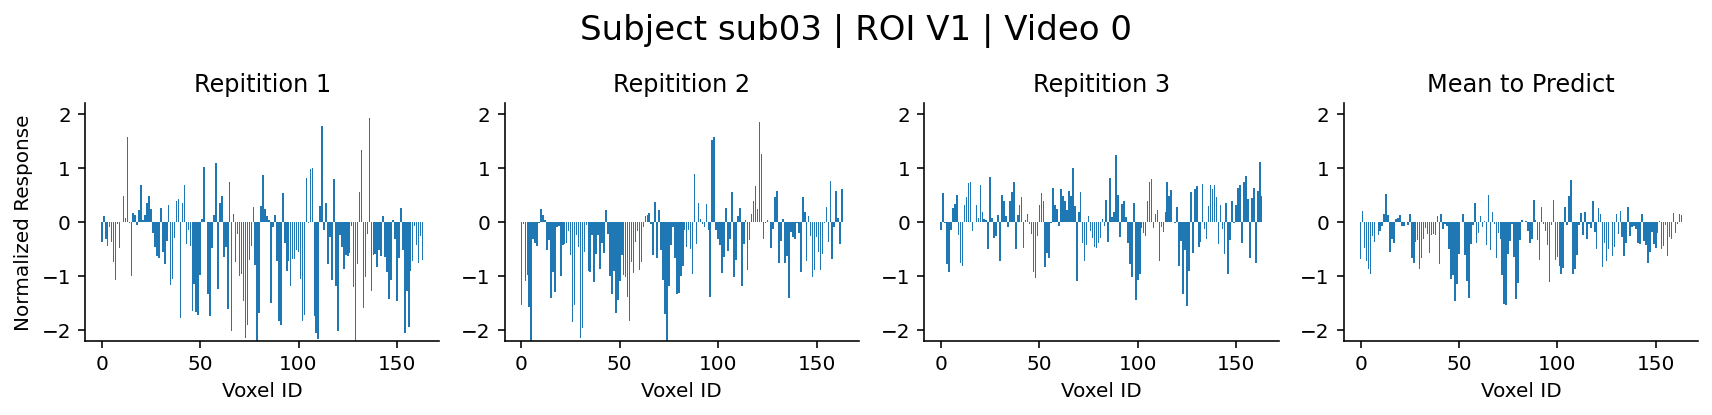

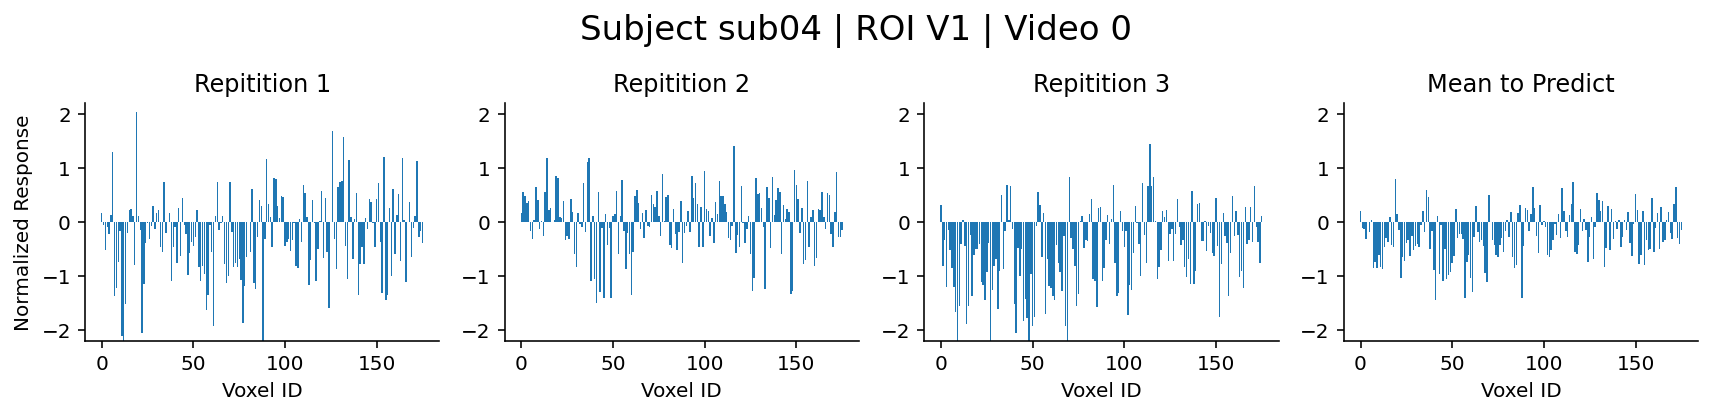

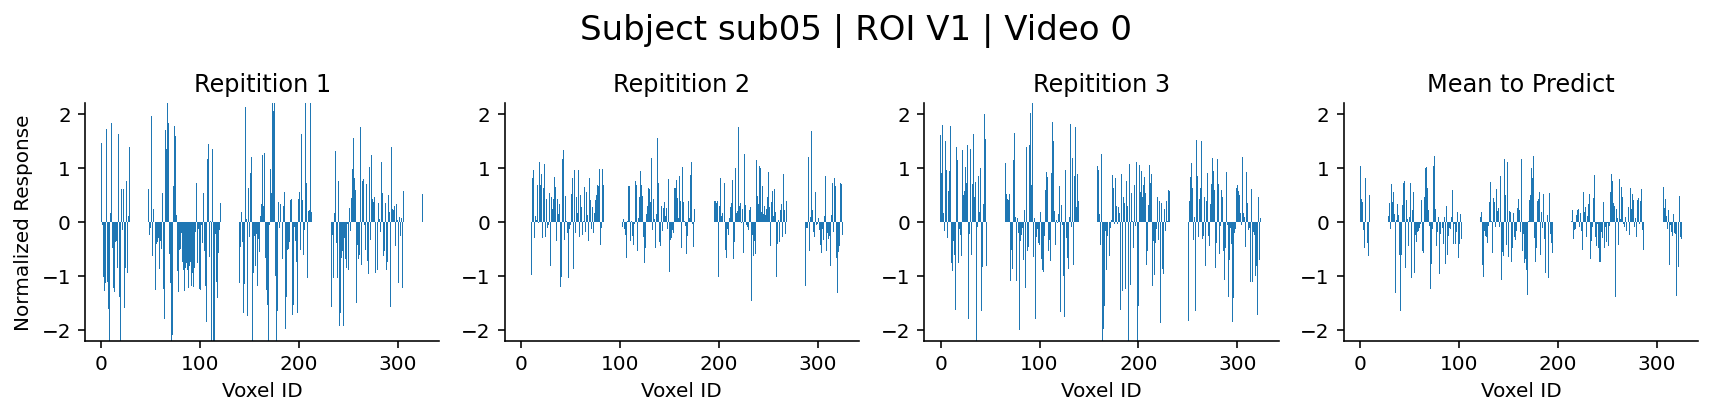

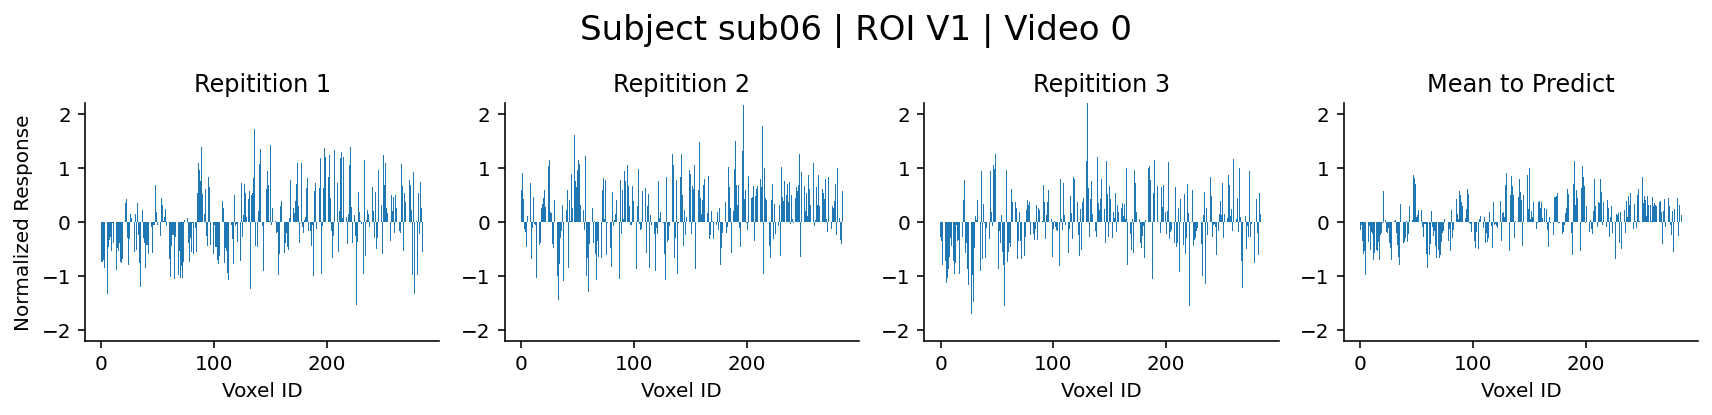

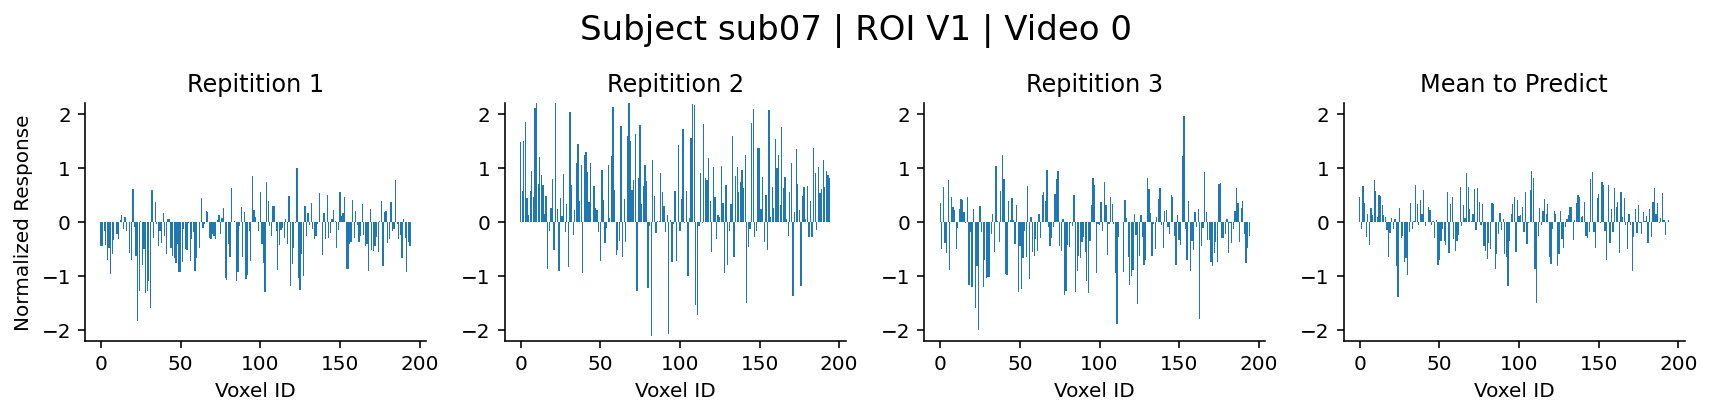

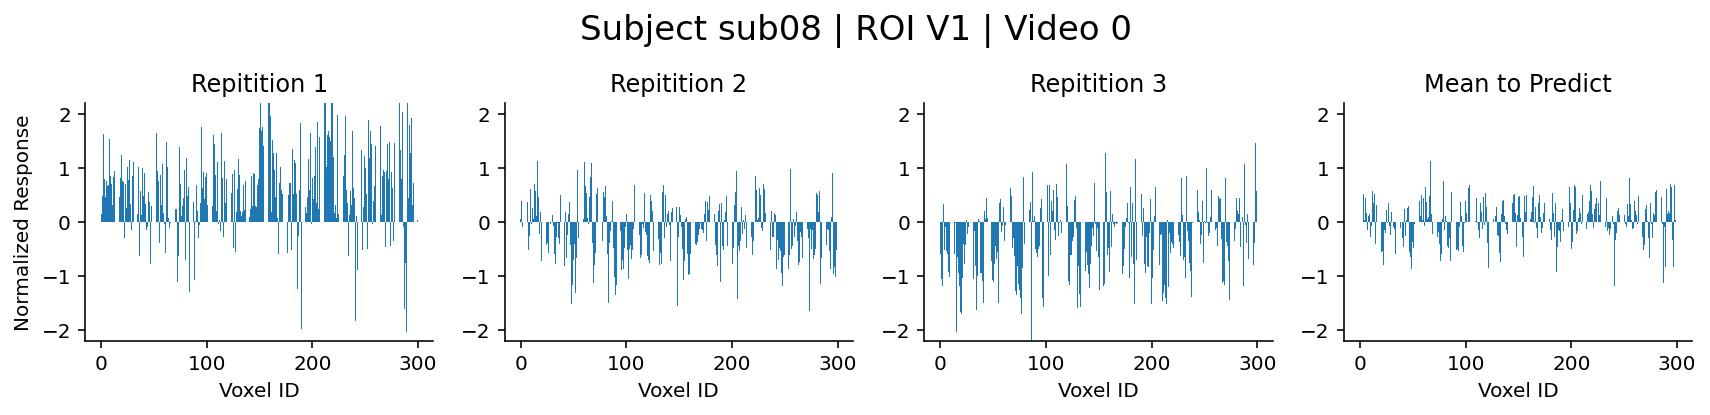

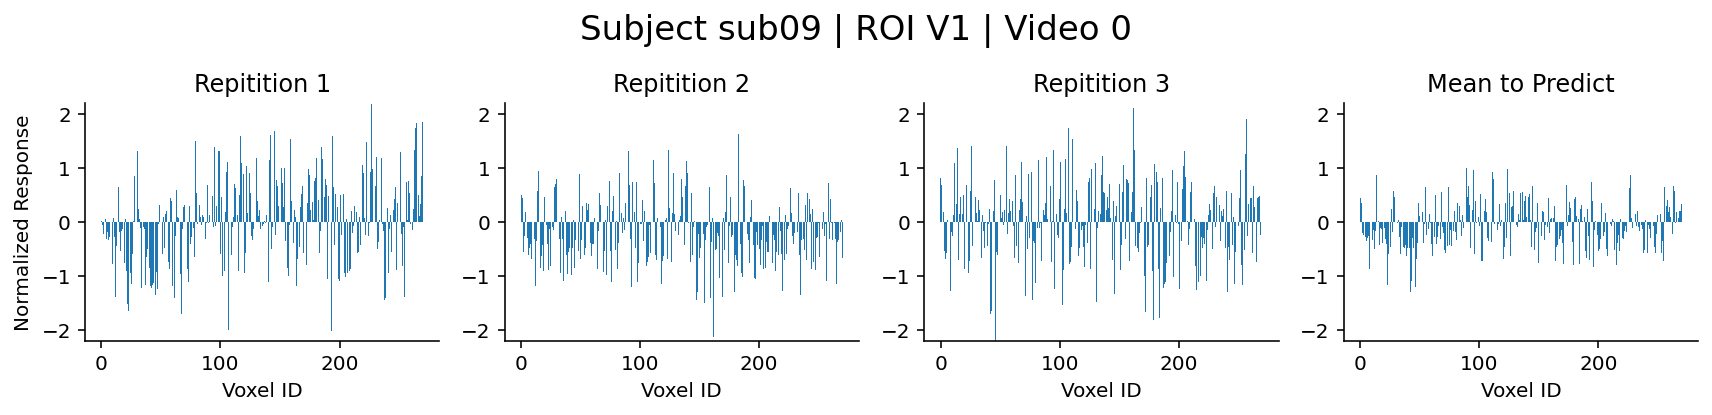

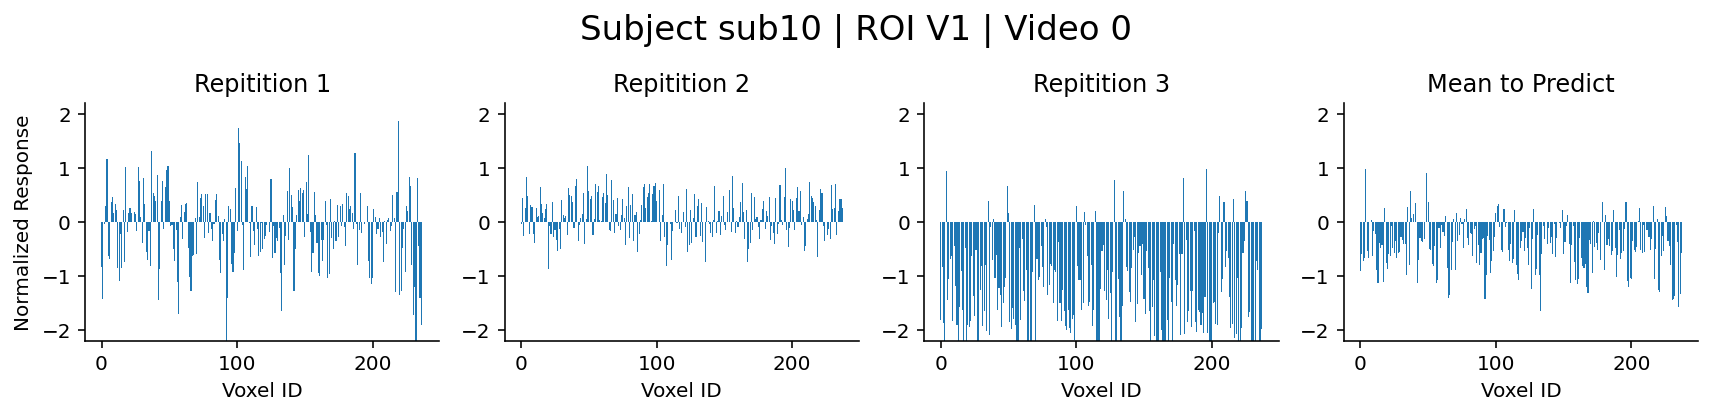

In [9]:
for sub in all_subjects:
    plot_voxel_response(video_id=0, track="mini_track", subject_id=sub, roi='V1')

In [300]:
import numpy as np
import scipy.stats as stats 
from matplotlib import pyplot as plt

all_activations = np.load("0001_0-0-1-6-7-2-8-0-17500167280_raw_layer_1.npy")
activations = all_activations[0]
num_frames = activations.shape[0]
activations.shape, num_frames

((45,), 45)

In [321]:
num_frames = 45
times = np.linspace(1, 100, num_frames) 
y1 = (stats.gamma.pdf(x, a=10) - 0.5*stats.gamma.pdf(x, a=20))
y1 = y1/sum(y1)

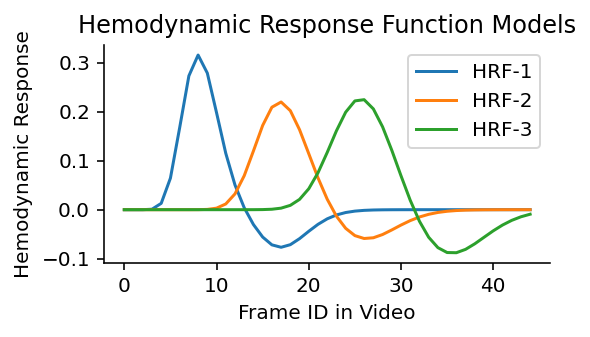

In [322]:
def hrf(times, peak=20, under=40, under_coeff=0.35):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = stats.gamma.pdf(times, peak)
    # Gamma pdf for the undershoot
    undershoot_values = stats.gamma.pdf(times, under)
    # Combine them
    values = peak_values - under_coeff * undershoot_values
    # Scale max to 0.6
    return values / np.sum(values)

hrf_1 = hrf(times)
hrf_2 = hrf(times, peak=40, under=60, under_coeff=0.35)
hrf_3 = hrf(times, peak=60, under=80, under_coeff=0.5)

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(hrf_1, label="HRF-1")
ax.plot(hrf_2, label="HRF-2")
ax.plot(hrf_3, label="HRF-3")
ax.set_xlabel("Frame ID in Video")
ax.set_ylabel("Hemodynamic Response")
ax.set_title("Hemodynamic Response Function Models")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

In [323]:
convolved_1 = np.convolve(activations, hrf_1)[:-(len(hrf_1) - 1)]
convolved_2 = np.convolve(activations, hrf_2)[:-(len(hrf_2) - 1)]
convolved_3 = np.convolve(activations, hrf_3)[:-(len(hrf_2) - 1)]


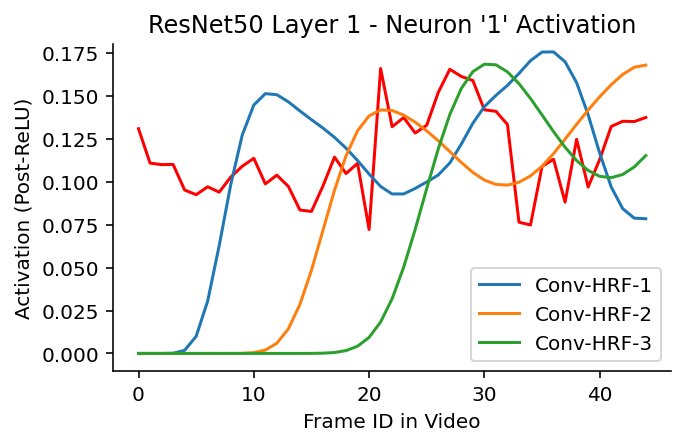

In [331]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(activations, c="r")
ax.plot(convolved_1, label="Conv-HRF-1")
ax.plot(convolved_2, label="Conv-HRF-2")
ax.plot(convolved_3, label="Conv-HRF-3")

#ax.plot(np.repeat(activations.mean(), num_frames), label="HRF-1")

#ax.plot(np.repeat(convolved.mean(), num_frames), label="Mean HRF-1")

ax.set_xlabel("Frame ID in Video")
ax.set_ylabel("Activation (Post-ReLU)")
ax.set_title("ResNet50 Layer 1 - Neuron '1' Activation")
ax.set_ylim(-0.01, 0.18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

In [307]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(all_activations)
x_train_trafo = pca.transform(all_activations)
print(pca.explained_variance_ratio_)

[0.65584239]
